In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [4]:
def _mean_safe(xs):
    try:
        return float(np.mean(xs)) if len(xs) else np.nan
    except Exception:
        return np.nan

def table_for(greedy_dict: dict, var: str) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(
        {
            int(iter_k): {
                country: _mean_safe(country_dict.get(var, []))
                for country, country_dict in countries.items()
            }
            for iter_k, countries in greedy_dict.items()
        },
        orient="index",
    )
    return df.sort_index()


## 1. Load results

In [35]:
scm_results_path = "../marl_results/20250918_135300_scm_final/marl_experiment_results_intermediate.json"

with open(scm_results_path, "r") as f:
    scm_results = json.load(f)

scm_training_time = pd.DataFrame.from_dict(scm_results["training_time_stats"], orient="index", columns=["value"]).iloc[:59]
scm_greedy_reward = pd.DataFrame.from_dict(scm_results["greedy_reward"], orient="index").iloc[:59]
scm_train_reward = pd.DataFrame.from_dict(scm_results["train_reward"], orient="index").iloc[:59]

scm_greedy_policy = scm_results["greedy_policy"]

scm_emission_delta  = table_for(scm_greedy_policy, "emission_delta").iloc[:59]
scm_prevention_rate = table_for(scm_greedy_policy, "prevention_rate").iloc[:59]

In [36]:
net_results_path = "../marl_results/20250918_123942_net/marl_experiment_results_intermediate.json"

with open(net_results_path, "r") as f:
    net_results = json.load(f)

net_training_time = pd.DataFrame.from_dict(net_results["training_time_stats"], orient="index", columns=["value"]).iloc[:59]
net_greedy_reward = pd.DataFrame.from_dict(net_results["greedy_reward"], orient="index").iloc[:59]
net_train_reward = pd.DataFrame.from_dict(net_results["train_reward"], orient="index").iloc[:59]

net_greedy_policy = net_results["greedy_policy"]

net_emission_delta  = table_for(net_greedy_policy, "emission_delta").iloc[:59]
net_prevention_rate = table_for(net_greedy_policy, "prevention_rate").iloc[:59]


## 2. Charts and figures

### 2.1 Training time

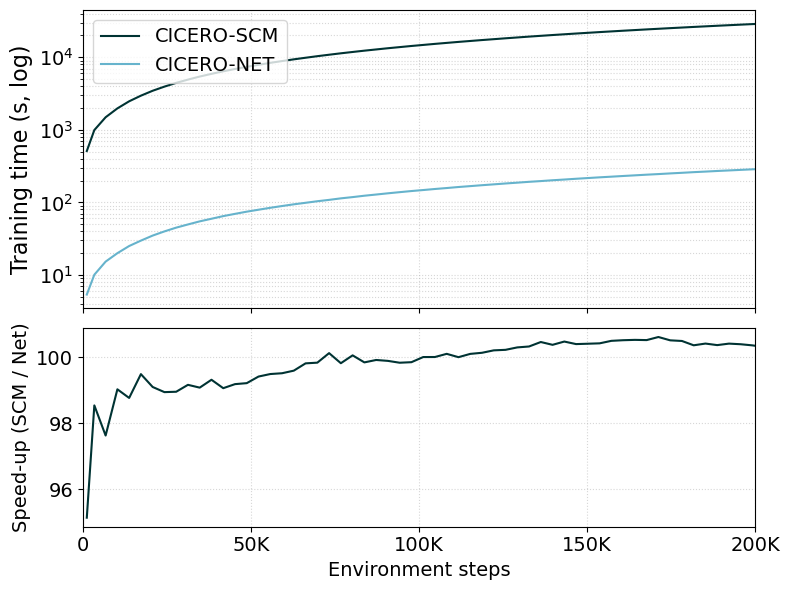

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric index
scm_training_time.index = scm_training_time.index.astype(int)
net_training_time.index = net_training_time.index.astype(int)

# Align
df = pd.concat(
    {"SCM": scm_training_time["value"], "Net": net_training_time["value"]},
    axis=1
).sort_index()

speedup = df["SCM"] / df["Net"]

# Get colormap and sample two colors
cmap = plt.get_cmap("ocean")
colors = [cmap(0.2), cmap(0.8)]  # pick two well-separated colors

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, height_ratios=[1.5, 1])

# --- (1) Absolute training times (log scale)
ax1.plot(df.index, df["SCM"], label="CICERO-SCM", color=colors[0])
ax1.plot(df.index, df["Net"], label="CICERO-NET", color=colors[1])
ax1.set_yscale("log")
ax1.set_ylabel("Training time (s, log)", fontsize=16)
ax1.grid(True, which="both", linestyle=":", alpha=0.5)
ax1.legend(fontsize=14, loc="upper left")
ax1.tick_params(axis="y", labelsize=14)

# --- (2) Relative speedup
ax2.plot(df.index, speedup, color=colors[0])
ax2.set_xlabel("Environment steps", fontsize=14)
ax2.set_ylabel("Speed-up (SCM / Net)", fontsize=14)
ax2.grid(True, linestyle=":", alpha=0.5)
ax2.tick_params(axis="y", labelsize=14)

# X-axis formatting
ax2.set_xlim(0, 200_000)
ticks = np.arange(0, 200_001, 50_000)
ax2.set_xticks(ticks)
ax2.set_xticklabels(["0"] + [f"{t//1000}K" for t in ticks[1:]], fontsize=14)

plt.tight_layout()
plt.savefig("plots/training_time_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


### 2.2 Reward over training steps

In [38]:
def plot_train_reward(
    scm_df: pd.DataFrame,
    net_df: pd.DataFrame,
    steps_max: int = 200_000,
    cmap: str = "cividis",
):
    # Ensure numeric x
    scm = scm_df.copy(); net = net_df.copy()
    scm.index = scm.index.astype(int); net.index = net.index.astype(int)

    # Common countries
    countries = [c for c in scm.columns if c in net.columns]
    scm = scm[countries].sort_index()
    net = net[countries].sort_index()

    # Palette: one shade per country
    cmap_obj = plt.get_cmap(cmap)
    colors = [cmap_obj(x) for x in np.linspace(0.15, 0.85, len(countries))]

    fig, ax = plt.subplots(figsize=(10, 6))

    scm_handles, net_handles = [], []
    for i, country in enumerate(countries):
        (h1,) = ax.plot(scm.index, scm[country], color=colors[i], linewidth=2.0, alpha=0.7)
        (h2,) = ax.plot(net.index, net[country], color=colors[i], linewidth=2.0, linestyle="--")
        scm_handles.append(h1); net_handles.append(h2)

    # Axes cosmetics
    ax.set_xlabel("Environment steps")
    ax.set_ylabel("Training reward")
    ax.set_title("Training reward per agent: SCM vs NET")
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.set_xlim(0, steps_max)
    ticks = np.arange(0, steps_max + 1, 50_000)
    ax.set_xticks(ticks)
    ax.set_xticklabels(["0"] + [f"{t//1000}K" for t in ticks[1:]])
    ax.margins(x=0)

    # --- Separate legends inside the plot ---
    leg1 = ax.legend(
        scm_handles,
        countries,
        title="SCM",
        frameon=True,
        loc="lower left",
        bbox_to_anchor=(0.7, 0.02),
    )
    ax.add_artist(leg1)

    leg2 = ax.legend(
        net_handles,
        countries,
        title="NET",
        frameon=True,
        loc="lower right",
        bbox_to_anchor=(0.99, 0.02),
    )

    plt.tight_layout()
    plt.show()

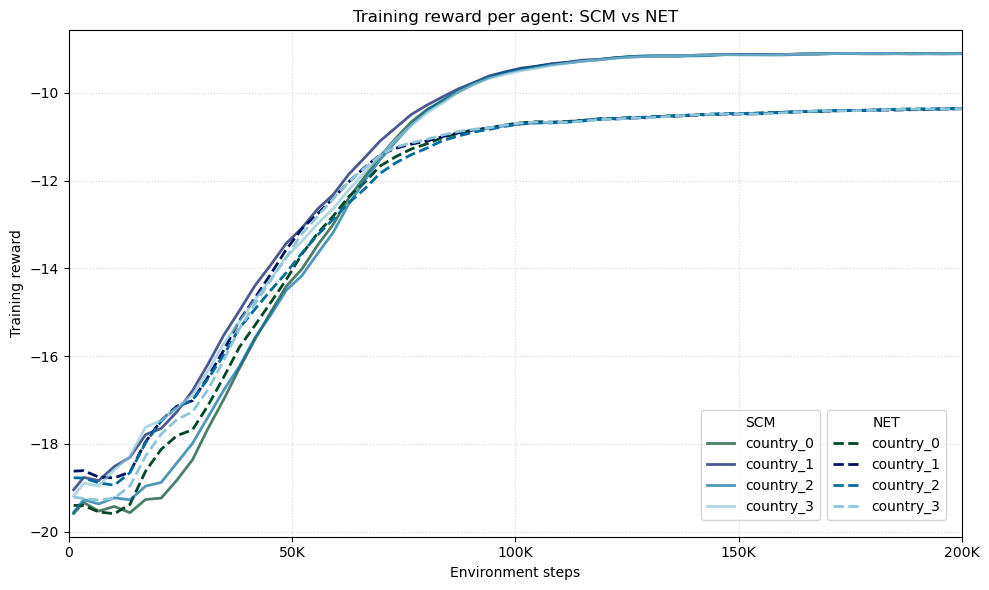

In [39]:
plot_train_reward(scm_train_reward, net_train_reward, steps_max=200_000,cmap="ocean")

### 2.3 Policy consistency

In [100]:
def _prep(df):
    df = df.copy()
    df.index = df.index.astype(int)
    return df.sort_index()

def _legend_pair(ax, left_handles, right_handles, labels, loc_left=(0.62,0.5), loc_right=(1,0.5)):
    leg1 = ax.legend(left_handles, labels, title="SCM", frameon=True,
                     loc="lower left", bbox_to_anchor=loc_left)
    ax.add_artist(leg1)
    ax.legend(right_handles, labels, title="NET", frameon=True,
              loc="lower right", bbox_to_anchor=loc_right)

def plot_policy_consistency(
    scm_emission_delta: pd.DataFrame,
    net_emission_delta: pd.DataFrame,
    scm_prevention_rate: pd.DataFrame,
    net_prevention_rate: pd.DataFrame,
    steps_max: int = 200_000,
    cmap: str = "cividis",
):
    # --- prep & align ---
    s_ed, n_ed = _prep(scm_emission_delta), _prep(net_emission_delta)
    s_pr, n_pr = _prep(scm_prevention_rate), _prep(net_prevention_rate)

    countries = [c for c in s_ed.columns if c in n_ed.columns]
    # keep same ordering across both variables
    s_ed, n_ed = s_ed[countries], n_ed[countries]
    s_pr, n_pr = s_pr[countries], n_pr[countries]

    # color per country (shared between SCM/NET; style distinguishes)
    cmap_obj = plt.get_cmap(cmap)
    colors = [cmap_obj(x) for x in np.linspace(0.15, 0.85, len(countries))]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # ---------- Panel 1: emission_delta ----------
    scm_handles, net_handles = [], []
    for i, c in enumerate(countries):
        (h1,) = ax1.plot(s_ed.index, s_ed[c], color=colors[i], linewidth=2.0)
        (h2,) = ax1.plot(n_ed.index, n_ed[c], color=colors[i], linewidth=2.0, linestyle="--")
        scm_handles.append(h1); net_handles.append(h2)
    ax1.set_ylabel("Emission Δ", fontsize=14)
    ax1.grid(True, linestyle=":", alpha=0.5)
    ax1.tick_params(axis="y", labelsize=14)
    _legend_pair(ax1, scm_handles, net_handles, countries)

    # ---------- Panel 2: prevention_rate ----------
    scm_handles, net_handles = [], []
    for i, c in enumerate(countries):
        (h1,) = ax2.plot(s_pr.index, s_pr[c], color=colors[i], linewidth=2.0, alpha = 0.7)
        (h2,) = ax2.plot(n_pr.index, n_pr[c], color=colors[i], linewidth=2.0, linestyle="--")
        scm_handles.append(h1); net_handles.append(h2)
    ax2.set_xlabel("Environment steps", fontsize=14)
    ax2.set_ylabel("Prevention rate", fontsize=14)
    ax2.tick_params(axis="y", labelsize=14)
    ax2.grid(True, linestyle=":", alpha=0.5)

    # x-axis formatting
    for ax in (ax1, ax2):
        ax.set_xlim(0, steps_max)
        ticks = np.arange(0, steps_max + 1, 50_000)
        ax.set_xticks(ticks)
        ax.set_xticklabels(["0"] + [f"{t//1000}K" for t in ticks[1:]], fontsize=14)
        ax.margins(x=0)

    plt.tight_layout()
    plt.show()



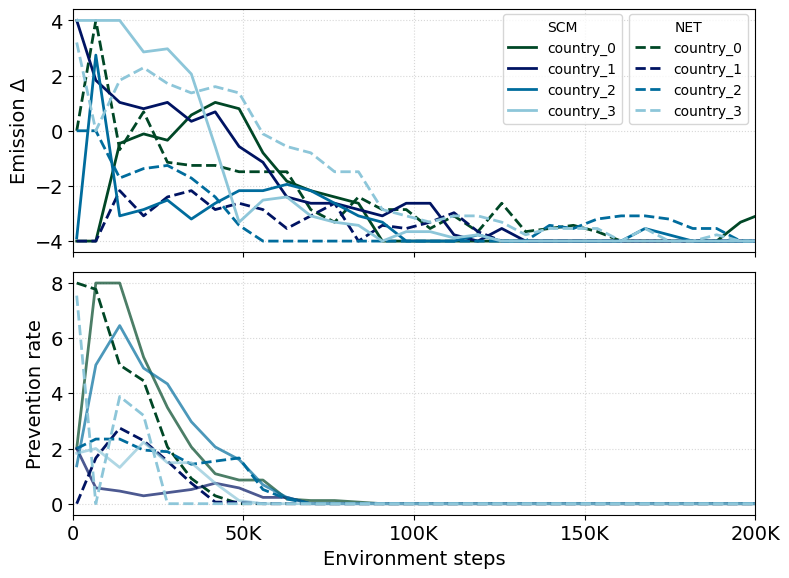

In [101]:
# Usage:
plot_policy_consistency(scm_emission_delta, net_emission_delta,
                        scm_prevention_rate, net_prevention_rate,
                        steps_max=200_000, cmap="ocean")